## Imports

In [1]:
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import os

%matplotlib widget

## Stage 1
For the first stage, we had to create a CSV file with each row having a timestamp, followed by 9 values of sensors. The challenge here is that every sensor has its own interrupts. These interrupts are captured by the OS and then passed on to the application via a registered handler. Assuming that we are getting data at the max frequency, the frequency at which every sensor will create an interrupt will be different. Not only that the frequency will not be the same with time either. As an example, the light sensor will not give any data if the light does not change. It is very easy to observe this on the application UI which shows the value. Whereas the magnetometer will keep giving interrupts as it is a lot more prone to ambient noise.

So if we want to capture all the data, we have to create time buckets (say 10 ms each) where we collect all the values from one sensor and then average them out for that bucket. Here in our experiments, we collected values for buckets with size 1ms, 5ms, 10ms, 20ms, 50ms. This bucketing mechanism is built in the **sensorcapture** package where the bucket is represented by **ReadingBucket** and the granularity and control of sensor events happens in **SensorCaptureTask**.

On running plot_stage_1(), the plots for the magnitude of acceleration (taken from magnitude of the vector represented by the data of accerelations in the x, y and z axes) versus time are displayed. The activity we were doing while taking readings was simple walking.

The thing to note is that all the graphs have the same trend and the features of the graph (like the different peaks, slopes between two points, etc) match up really well. This proves that the information loss in our bucketing mechanism will not affect our step counter code.

**Deliverables**: The csv files corresponding to the data asked in stage 1 is stored in Stage 1 folder. You are free to check any csv file in the folder.

In [2]:
def plot_stage_1():
    BUCKET_SIZES = ['1','5','10','20','50']
    for bucket_size in BUCKET_SIZES:
        df = pd.read_csv('./Stage 1/' + bucket_size + '_data.csv')
        df[str(bucket_size) + '_' + 'mag_acc'] = np.sqrt(pow(df['acc_x'],2)+pow(df['acc_y'],2)+pow(df['acc_z'],2))
        
        df[df['Timestamp'] > 40000].plot(x='Timestamp', y=str(bucket_size) + '_' + 'mag_acc', figsize=(8,5))

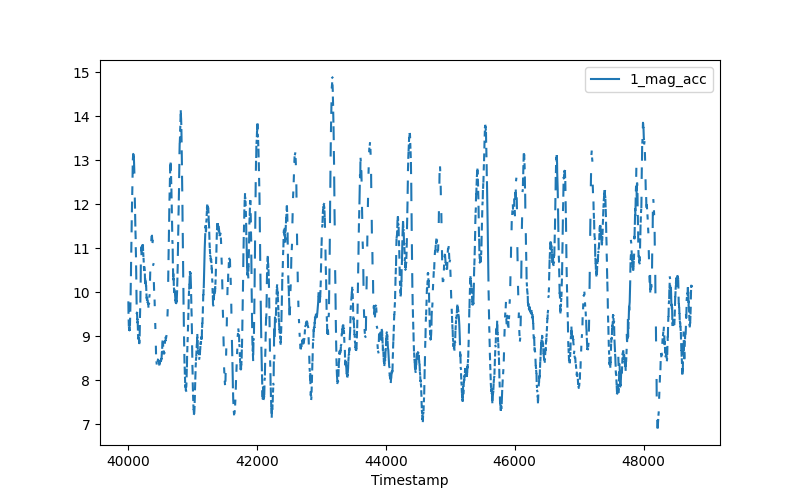

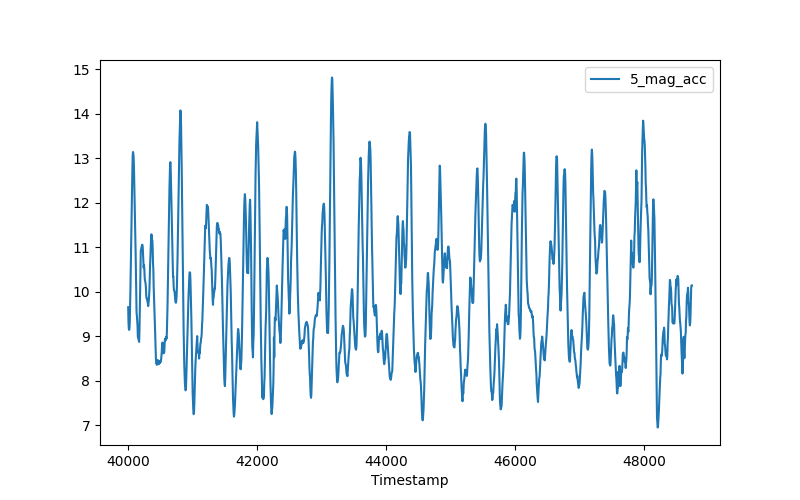

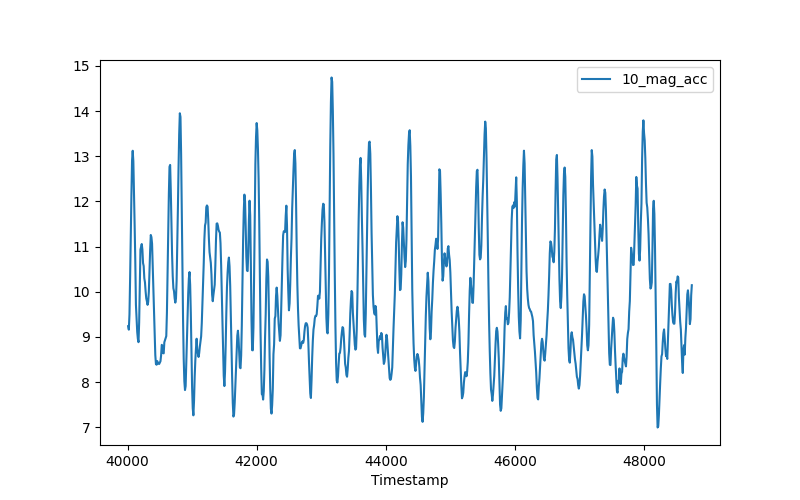

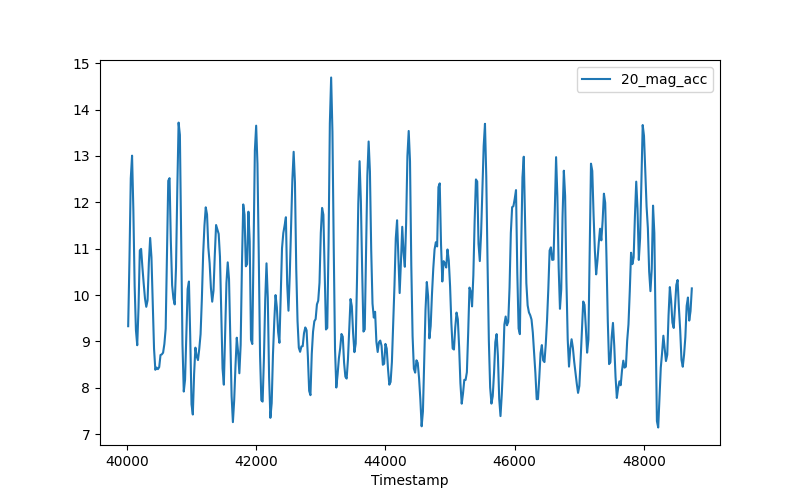

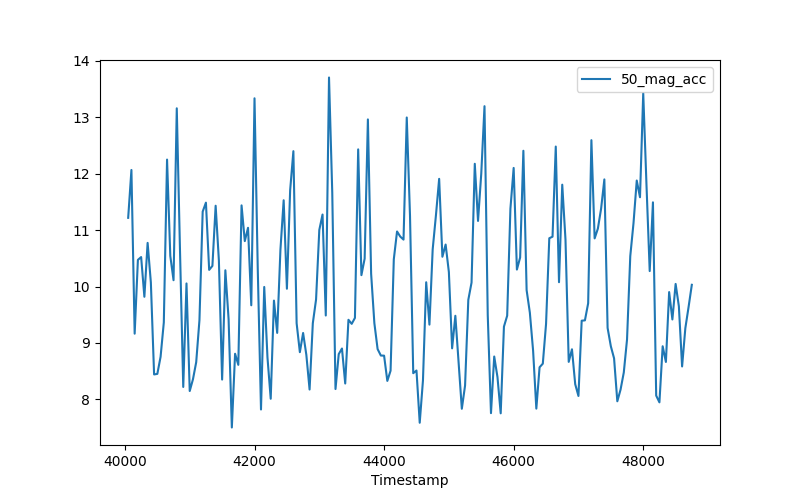

In [3]:
plot_stage_1()

___
## Stage 2

We used the program implemented in stage 1 to take readings for 5 different activities while holding the phone in the manner described in the assignment PDF. We used a 25 metre long corridor for walking, running. Jumping and idling were done in one place. Stairs was done by walking down two flights of 8 stairs each.

**Deliverables**: The csv files corresponding to the five activities can be found in the Stage 2 folder. We have used files corresponding to bucket size 50 for this. Note that there is no loss of information due to bucket size 50, as demonstrated above.
Note: The file names do not match the exact format specified in the assignment because of the host OS not allowing files to have certain characters like : colon and - hyphen . The format we are using is LABEL ddmmyyhhmmss DISTANCE.csv The activity Stairs has no distance associated with it.

On running plot_stage_2(), you will find the plots for the magnitude of acceleration for each of the activities. We will attempt to distinguish them later in stage 4. For now, it suffices to understand that Idle has the lowest range of acceleration magnitude due to the phone just being stationary. The range of Stairs and Walking is similar, however the curves are qualitatively different. Running and Jumping have far higher ranges than the previous three, with Jumping having the noticeably largest range.

In [4]:
def plot_stage_2():
    ACTIVITIES = ['Idle', 'Stairs', 'Walking', 'Running', 'Jumping']
    for activity in ACTIVITIES:
        df = pd.read_csv('./Stage 2/' + activity + '/' + os.popen('ls ./Stage\ 2/' + activity).read()[:-1])
        df[activity + '_mag_acc'] = np.sqrt(pow(df['acc_x'],2)+pow(df['acc_y'],2)+pow(df['acc_z'],2))
        df.plot(x='Timestamp', y = activity + '_mag_acc')

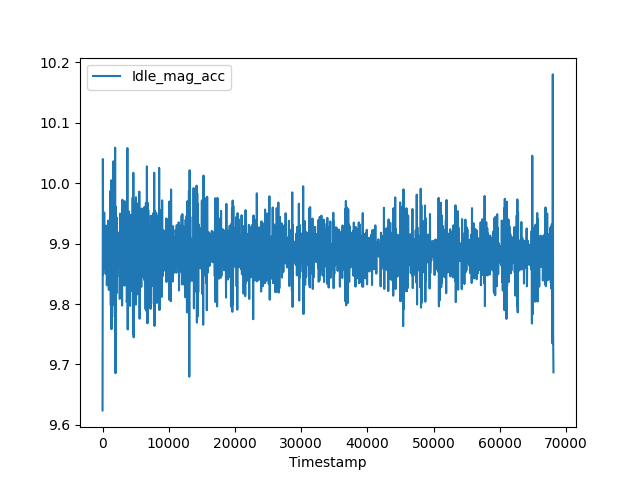

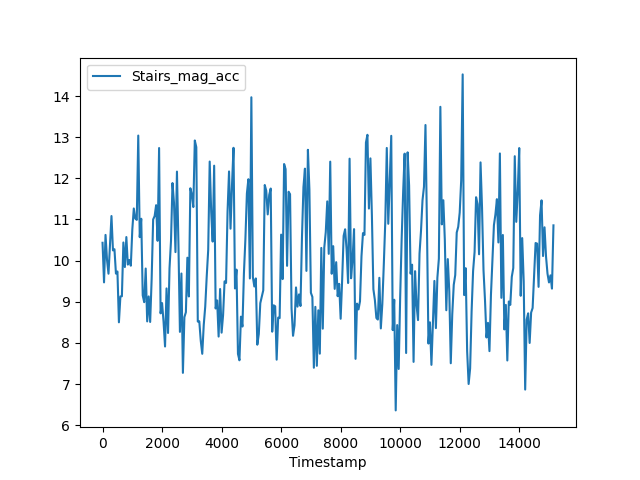

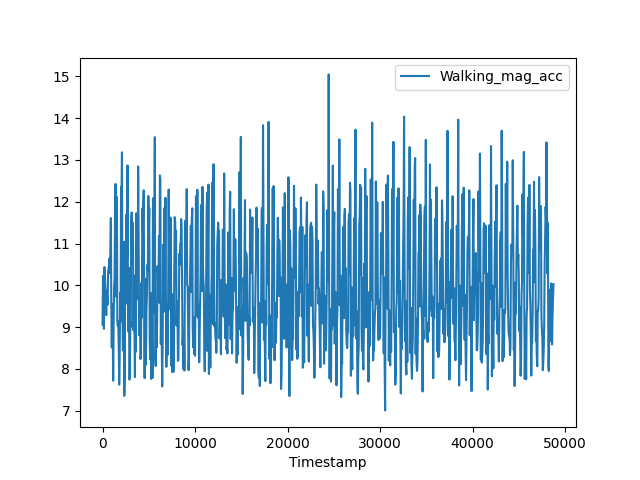

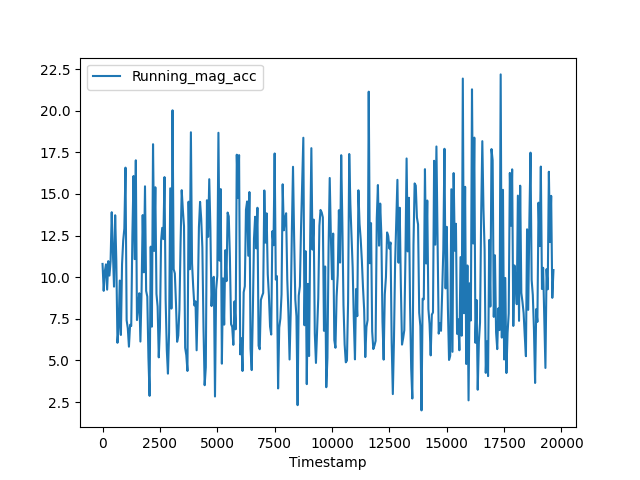

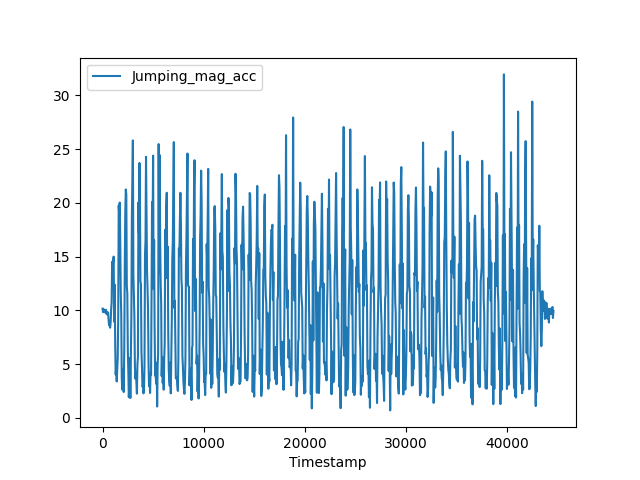

In [5]:
plot_stage_2()

___
## Stage 3

For implementing the stage detection algorithm, we started by testing out a simple peak detection algoritm. The idea was that at the end points of the physical process of walking, the phone will suddenly change the direction. We can capture this via checking for the acceleration change peaks.

1. The first step we had a smoothing algorithm which used a bellcurve on the point's immediate neighbourhood to smooth out the data.
2. Then we counted the number of local maximas we encountered in the local window and incremented the steps counter with this number.

The issue with this algorithm was that in a small window, we saw that there were multiple such local minima even after smoothing the data. Also depending on where the phone location relative to the human (top or bottom pocket, tied to hands or legs, purse, in-hand etc) the number of the peaks we can physically expect is variable. Since it is not feasible to get the location of the phone, we had to search for a way to add this as an invariance in our mechanism.

We then found a Windowed-Peak detection methodology in the paper [An Optimised Algorithm for Accurate Steps Counting From Smart-Phone Accelerometry (2013)](https://www.researchgate.net/publication/328990649_An_Optimised_Algorithm_for_Accurate_Steps_Counting_From_Smart-Phone_Accelerometry) in Conference: 2018 40th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC).

We combined the ideas (and the grid search results for optimal parameters) from this paper with our original naive idea and created the following three processing steps. This algorithm also worked on the magnitude of acceleration which we already had calculated.

1. Stage 1 (Smoothening) : Apply a smoothening process to clean the input signal and remove noise. This step is the same as before. The paper uses a low pass filter, but the guassian filter we used in our code also works as a low pass filter. [Guassian Blur](https://en.wikipedia.org/wiki/Gaussian_blur#Low-pass_filter).
2. Stage 2 (Exaggeration) : Make the peaks in the signal exaggerated and normalized, to ensure that it is easy to detect a peak. This normalized data is centered around 0 and has the peaks exaggerated to be clearly visible.
3. Stage 3 (Detection) : Compute running averages for mean and standard deviation. Determine a candidate peak by checking if it's acceleration is a threshold number of standard deviations away from the mean. Ensure that you are picking only one peak (the maximum magnitude peak) in the window of consideration. This algorithm also adds the condition of the current value being beyond a certain number of standard deviations from the mean. All the multiple local minimas in a time window (which can be defined from the minimum possible time for a step) can be then clubbed. Here we are using [Welford's online algorithm](https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm) for calculating the (unbiased) standard deviation online.

![Visual depiction](files/images/algodescription.png)

Implementation details:
We have implemented each stage as a separate thread in our Android Studio code which communicate via a linear producer consumer architechture defined by **AbstractStage** in the **stepcounter** package. This kept our code organized and ensured easy debugging. Each stage is connected to the next stage via queues to ensure passing of sensor readings between stages. The parameters we have used (such as detection window size, detection threshold value, parameters for implementing low pass filters) have all been optimized using a grid search done by the authors of the paper. The values of the parameters that gave the least Mean Absolute Error have been reported by the authors and used by us in our implementation.

___
## Stage 4


### Create a merged dataframe

In [6]:
ACTIVITIES = ['Idle','Stairs','Walking','Running','Jumping']
merged_df = pd.DataFrame()
for activity in ACTIVITIES:
    df = pd.read_csv('./Stage 2/' + activity + '/' + os.popen('ls ./Stage\ 2/' + activity).read()[:-1])
    df[activity + '_mag_acc'] = np.sqrt(pow(df['acc_x'],2)+pow(df['acc_y'],2)+pow(df['acc_z'],2))
        
    if len(merged_df.index) == 0:
        merged_df = df[['Timestamp', activity + '_mag_acc']]
    else:
        merged_df = pd.merge(merged_df, df[['Timestamp', activity + '_mag_acc']], on='Timestamp')

### Group the merged dataframe into 0.2 second interval buckets as asked in the assignment

In [7]:
merged_df['Timestamp bucket'] = (merged_df['Timestamp'] // 200) * 200
merged_df = merged_df.drop('Timestamp', 1)
merged_df

,Idle_mag_acc,Stairs_mag_acc,Walking_mag_acc,Running_mag_acc,Jumping_mag_acc,Timestamp bucket
0,9.624017,10.434484,9.056992,10.797216,10.161197,0
1,10.039930,9.472214,10.227631,9.180802,9.833567,0
2,9.849172,10.625443,10.194538,10.357861,10.119053,0
3,9.914729,10.020754,8.957774,10.771258,10.067268,0
4,9.867538,9.682949,10.435664,9.252519,9.846488,200
...,...,...,...,...,...,...
299,9.879681,9.684747,13.552982,9.328849,3.311849,14800
300,9.971253,9.470416,8.801763,13.025025,1.974191,15000
301,9.816581,9.642601,9.356137,8.134215,4.747126,15000
302,9.889863,9.320292,9.501930,5.030679,4.399159,15000


### Compute mean, median, max, variance, and zero-crossings for the intervals

Note: Although we have written the code to compute zero crossings, zero crossings makes no sense for our case since the magnitude of acceleration will never ever go below zero.

In [8]:
grouped_merged_df_mean = merged_df.groupby(['Timestamp bucket']).mean()
grouped_merged_df_mean = grouped_merged_df_mean.rename(columns={'Walking_mag_acc':'Walking_mag_acc_mean','Running_mag_acc':'Running_mag_acc_mean','Jumping_mag_acc':'Jumping_mag_acc_mean','Stairs_mag_acc':'Stairs_mag_acc_mean','Idle_mag_acc':'Idle_mag_acc_mean'})

grouped_merged_df_median = merged_df.groupby(['Timestamp bucket']).median()
grouped_merged_df_median = grouped_merged_df_median.rename(columns={'Walking_mag_acc':'Walking_mag_acc_median','Running_mag_acc':'Running_mag_acc_median','Jumping_mag_acc':'Jumping_mag_acc_median','Stairs_mag_acc':'Stairs_mag_acc_median','Idle_mag_acc':'Idle_mag_acc_median'})

grouped_merged_df_max = merged_df.groupby(['Timestamp bucket']).max()
grouped_merged_df_max = grouped_merged_df_max.rename(columns={'Walking_mag_acc':'Walking_mag_acc_max','Running_mag_acc':'Running_mag_acc_max','Jumping_mag_acc':'Jumping_mag_acc_max','Stairs_mag_acc':'Stairs_mag_acc_max','Idle_mag_acc':'Idle_mag_acc_max'})

grouped_merged_df_variance = merged_df.groupby(['Timestamp bucket']).var()
grouped_merged_df_variance = grouped_merged_df_variance.rename(columns={'Walking_mag_acc':'Walking_mag_acc_variance','Running_mag_acc':'Running_mag_acc_variance','Jumping_mag_acc':'Jumping_mag_acc_variance','Stairs_mag_acc':'Stairs_mag_acc_variance','Idle_mag_acc':'Idle_mag_acc_variance'})

grouped_merged_df_walking_zerocrossings = pd.DataFrame(columns=['Timestamp bucket', 'Walking_mag_acc_zerocrossings'])
for i in range(0,len(merged_df.index), 4):
    count = 0
    for j in range(i, i + 3):
        if merged_df['Walking_mag_acc'][i] * merged_df['Walking_mag_acc'][i+1] < 0:
            count += 1
    grouped_merged_df_walking_zerocrossings.loc[len(grouped_merged_df_walking_zerocrossings.index)] = [merged_df['Timestamp bucket'][i], count] 
    

### Merge all dataframes for ease of plotting and apply tags to them

In [9]:
mega_merge = pd.merge(pd.merge(pd.merge(grouped_merged_df_mean, grouped_merged_df_median, on='Timestamp bucket'), grouped_merged_df_max, on='Timestamp bucket'), grouped_merged_df_variance, on='Timestamp bucket') 

walking_merge = mega_merge[['Walking_mag_acc_mean', 'Walking_mag_acc_median', 'Walking_mag_acc_max', 'Walking_mag_acc_variance']].copy()
running_merge = mega_merge[['Running_mag_acc_mean', 'Running_mag_acc_median', 'Running_mag_acc_max', 'Running_mag_acc_variance']].copy()
jumping_merge = mega_merge[['Jumping_mag_acc_mean', 'Jumping_mag_acc_median', 'Jumping_mag_acc_max', 'Jumping_mag_acc_variance']].copy()
stairs_merge = mega_merge[['Stairs_mag_acc_mean', 'Stairs_mag_acc_median', 'Stairs_mag_acc_max', 'Stairs_mag_acc_variance']].copy()
idle_merge = mega_merge[['Idle_mag_acc_mean', 'Idle_mag_acc_median', 'Idle_mag_acc_max', 'Idle_mag_acc_variance']].copy()

tag = ['walking' for x in range(len(walking_merge.index))]
walking_merge['tag'] = tag
tag = ['running' for x in range(len(running_merge.index))]
running_merge['tag'] = tag
tag = ['jumping' for x in range(len(jumping_merge.index))]
jumping_merge['tag'] = tag
tag = ['stairs' for x in range(len(stairs_merge.index))]
stairs_merge['tag'] = tag
tag = ['idle' for x in range(len(idle_merge.index))]
idle_merge['tag'] = tag

## Plotting the activities
We can see from the graph that Jumping is the most spread out activity owing to high variance, followed by Running. Stairs and Walking are very similar. All the idle points are concentrated in a black dot, which you can view better by running the code and dragging things around. We are providing different views of the 3D plot, followed by one view where we plot only Jumping and Idle, to help better view Idle.

Jumping and Idle (black circle shows Idle dots)
![VIEW 1](files/images/view1.png)
All activities : 
![VIEW 2](files/images/view2.png)
All activities (different view) : 
![VIEW 3](files/images/view3.png)

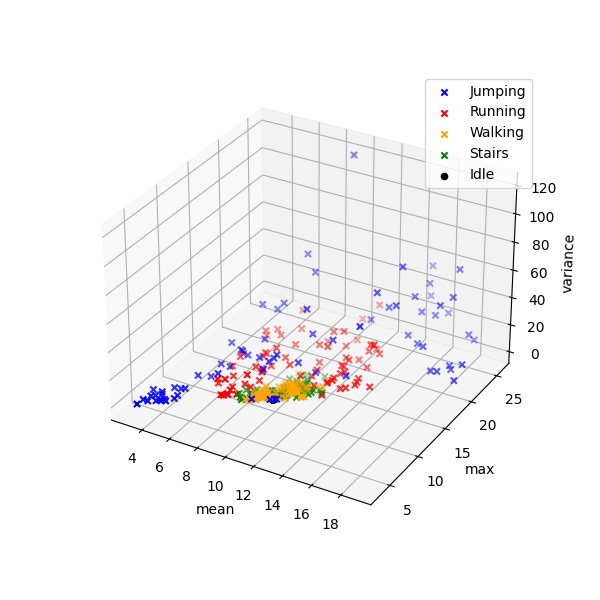

In [10]:
plot = plt.figure(figsize=(6,6))
plot = plt.axes(projection='3d')

merge_dict = {}
merge_dict['Jumping'] = jumping_merge
merge_dict['Running'] = running_merge
merge_dict['Walking'] = walking_merge
merge_dict['Stairs'] = stairs_merge
merge_dict['Idle'] = idle_merge

color = {}
color['Jumping'] = 'blue'
color['Running'] = 'red'
color['Walking'] = 'orange'
color['Stairs'] = 'green'
color['Idle'] = 'black'

def plot_stage_4(activities, features):
    for activity in activities:
        X = merge_dict[activity][activity + "_mag_acc_" + features[0]]
        Y = merge_dict[activity][activity + "_mag_acc_" + features[1]]
        Z = merge_dict[activity][activity + "_mag_acc_" + features[2]]
        if activity == 'Idle':
            _ = plot.scatter3D(X, Y, Z, label=activity, color=color[activity])
        else:
            _ = plot.scatter3D(X, Y, Z, label=activity, marker='x', color=color[activity])
    plot.set_xlabel(features[0])
    plot.set_ylabel(features[1])
    plot.set_zlabel(features[2])
    plot.legend()
    

activities=['Jumping', 'Running', 'Walking', 'Stairs', 'Idle']
features=['mean','max','variance']
plot_stage_4(activities, features)



